# Sept 16, 2018 Trend Detection CSCI E-82 Homework 2
### Due: October 1, 2018 11:59pm EST

## Overview

***Identifying technology trends is of core importance to venture capitalists, companies and individuals who may invest money or time to pursue the hottest areas. Using historic data, the goals are to characterize either an increase or decrease in certain areas over a span of time, and use that information to predict the next areas before everyone becomes aware of the trend. Economists and financial traders routinely develop methods to achieve this goal using numeric data, but that’s a different problem.***

Mining published literature for trend detection is not a new area, but it is far from being adequately solved. There are a number of papers that describe case studies for a given area, but none offer a definitive approach; most focus on only a niche area. The two main approaches to the problem are using word concepts and citation networks. The word concept approach aims to characterize a subfield by its component terms automatically and then look for patterns over time. Google Trends offers a plot of word frequency over time, but subfields tend to be more complex in that “convolutional neural network” has synonyms or abbreviations (CNN) that can be ambiguous. Furthermore, as areas mature, the concepts may refine into distinct groups and associate with specific sets of terms. The citation network looks for patterns in which authors are referenced to characterize concepts. These can be used to separate different areas based on which paper is cited, but also tend to be fairly noisy.
This homework will give you and a required partner a chance to develop your text mining skills to computationally find the top 10 upward or downward trending areas within the context of 30 years of the Neural Information Processing Systems (NIPS) proceedings for their annual conference.

## Data Set
The official data set is the NIPS Proceedings available at https://papers.nips.cc/. However, this will take a long time to download and hammer their server so we will would like to provide you with alternatives. There is a version of the dataset here: https://www.kaggle.com/benhamner/nips-papers. You will need a Kaggle login in order to download it. Since I would prefer everyone spend more time on the analysis and less time on the cleaning, I am working to put out a slightly cleaner version of the official data set shortly that I will post.
Partners:
  HW2 is a partnered homework so work should be completed with 1 partner. To help everyone find a partner, we ask you to sign up by putting your partner's first name next to yours and vice versa using this shared spreadsheet: https://docs.google.com/spreadsheets/d/1oz0pNYx8X2WptwiLsD9zMUtsCVZiEUTFXZ5DEnPaewk/edit?u
 sp=sharing. This will give everyone immediate feedback on who doesn't have a partner.
To select a partner, the self-intros on piazza are a good place to start. Please use the Canvas email to contact them since we respect your privacy and don't want to post everyone's email.
  
## Suggestions on Strategies
You are welcome to pursue any approach. If you find applicable methods online, feel free to use them and be sure to cite the results. I would recommend starting with the text mining pipeline described in lecture and section to clean the documents and identify single- and perhaps multi-word terms. In this case, the first pass might be to perform simple counting as a baseline over time and work for a standard approach to plot trends taking the normalization into account. In the next pass, you might expand from the isolated word terms to synonyms to larger concept subfields that may cluster together. The citations or co-related words can be helpful for this. Further refinements might be to include only certain sections of the documents or try weighting schemes.

## Grading Philosophy
We will grade based on 1) your success in the project so label your final result, and 2) your exploration of different ideas. Please document your success, but also document your rationale and failed approaches. We want to know which hypotheses you pursued and how they panned out. With these kinds of homework, we expect both partners to work together and contribute equally to a greater result than either could do alone given the time constraints. We will post a form to assess your partner’s contribution relative to yours.

## What to Submit
Please submit your python notebook and associated pdf of that notebook. In a separate document, please also submit a brief description (1-2 paragraphs each) as a separate document to address the following:
1. How have you defined a trend? How can you separate it from background noise and/or spurious relationships?
2. What are the main techniques you have used and how have you tailored them for this problem?
3. What was your strategy for finding multi-word phrases versus single words?
4. What approach(es) did you use to separate one subfield from others?
5. What parts of the document did you use and why?
6. How did you normalize the results against the growth of the conference, lengths of documents, etc.?
7. We know that you can look back and find trends but how would you find the next trend with your method? Be specific.
8. Plot of the final top 10 normalized trends as a function of time.

To assist the grading within the notebook:

* Label your final approach within the file for grading purposes.
* Flag the distinct approaches with a header describing your strategy and corresponding results.

It makes it much easier to follow your rationale with headers and descriptions than trying guess using the code alone.
We hope that you find this to be an interesting problem.

In [1]:
import pandas as pd
import numpy as np
import re
import string
from time import time
import spacy
from tld import get_tld
from sklearn.base import TransformerMixin

In [2]:
# read in authors table
authors = pd.read_csv('data/authors.csv')
authors.set_index('id', drop=True, inplace=True)
authors.index.name = 'author_id'

# print details of authors table
print('Authors table:\n', '*'*50)
print('There are %i unique authors' %authors.index.nunique())
print('Shape of authors table %s \n' %str(authors.shape))
# print(authors.head(), '\n\n')

# read in paper authors map
paper_authors = pd.read_csv('data/paper_authors.csv')
paper_authors.set_index('id', inplace=True, drop=True)

# print details about paper authors map
print('Paper Author table:\n', '*'*50)
print('There exist %i papers authored by %i unique authors' 
     %(paper_authors.paper_id.nunique(), paper_authors.author_id.nunique()))
paper_authors['paper_author_id'] = paper_authors['paper_id'].astype(str) + '_' + paper_authors['author_id'].astype(str)
print('There are %i unique author/paper pairs' %paper_authors['paper_author_id'].nunique())
print('Shape of Paper Author table %s\n' %str(paper_authors.shape))
# print(paper_authors.head(), '\n\n')

# read in papers
papers = pd.read_csv('data/papers.csv')
papers.set_index('id', inplace=True)
papers.index.name = 'paper_id'

# print details about papers table
print('Papers table:\n', '*'*50)
print('There exist %i papers with %i unique titles' 
     %(papers.index.nunique(), papers.title.nunique()))
print('Shape of Papers table %s\n' %str(papers.shape))
# print(papers.head(), '\n\n')

# map author names 
print('Combining data to one structure\n', '*'*50)
print('Mapping author names to the Paper Authors table in preparation to merge')
author_map = dict(zip(authors.index.values, authors.name.values))
paper_authors['author'] = paper_authors['author_id'].map(author_map)

# outer join of papers/authors
papers.reset_index(inplace=True, drop=False)
df = paper_authors.merge(papers, on='paper_id', how='outer')

# print outputs
print('After merging there are %i missing values in the author field' %df.author.isnull().sum())
df.loc[df.author.isnull(), 'author'] = 'UNKNOWN'
print('Final shape of data %s\n\n' %str(df.shape))

df.head()

Authors table:
 **************************************************
There are 9784 unique authors
Shape of authors table (9784, 1) 

Paper Author table:
 **************************************************
There exist 7238 papers authored by 9784 unique authors
There are 20823 unique author/paper pairs
Shape of Paper Author table (20838, 3)

Papers table:
 **************************************************
There exist 7241 papers with 7241 unique titles
Shape of Papers table (7241, 6)

Combining data to one structure
 **************************************************
Mapping author names to the Paper Authors table in preparation to merge
After merging there are 3 missing values in the author field
Final shape of data (20841, 10)




,paper_id,author_id,paper_author_id,author,year,title,event_type,pdf_name,abstract,paper_text
0,63,94.0,63_94,Yaser S. Abu-Mostafa,1987,Connectivity Versus Entropy,NaN,63-connectivity-versus-entropy.pdf,Abstract Missing,1\n\nCONNECTIVITY VERSUS ENTROPY\nYaser S. Abu...
1,80,124.0,80_124,Joshua Alspector,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...
2,80,125.0,80_125,Robert B. Allen,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...
3,80,126.0,80_126,Victor Hu,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...
4,80,127.0,80_127,Srinagesh Satyanarayana,1987,Stochastic Learning Networks and their Electro...,NaN,80-stochastic-learning-networks-and-their-elec...,Abstract Missing,9\n\nStochastic Learning Networks and their El...


In [3]:
df.groupby('event_type').count()

,paper_id,author_id,paper_author_id,author,year,title,pdf_name,abstract,paper_text
event_type,,,,,,,,,
Oral,351,351,351,351,351,351,351,351,351
Poster,7253,7250,7250,7253,7253,7253,7253,7253,7253
Spotlight,550,550,550,550,550,550,550,550,550


author
Michael I. Jordan     0.004846
Bernhard Sch?lkopf    0.002975
Yoshua Bengio         0.002879
Geoffrey E. Hinton    0.002783
Zoubin Ghahramani     0.002447
Name: title, dtype: float64

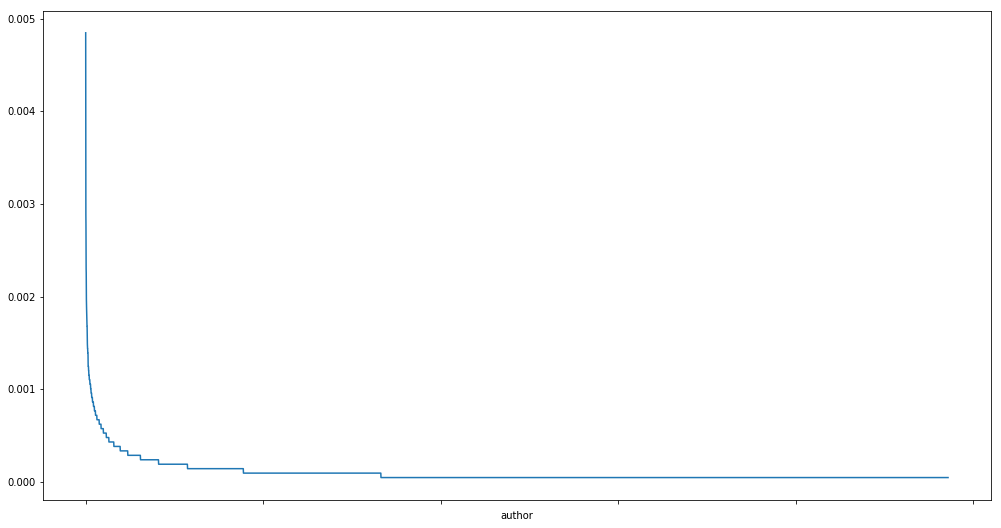

In [4]:
%matplotlib inline
# pareto principle for author output
_ = df.groupby('author').title.count().sort_values(ascending=False) / df.groupby('author').title.count().sum()
_.plot(figsize=(17, 9))
_.head()

In [5]:
################################################################################
# FILE: custom_classes.py
# DESCR: text cleaner
################################################################################

# IMPORT STATEMENTS
import re
import string
from time import time

import spacy
from tld import get_tld
from sklearn.base import TransformerMixin


# CLASS DEFINITIONS
class TextCleaner(TransformerMixin):
    """Text cleaning to slot into sklearn interface"""

    def __init__(self, remove_stopwords=True, remove_urls=True,
                 remove_puncts=True, lemmatize=True, extra_punct='',
                 custom_stopwords=[], custom_non_stopwords = [],
                 verbose=True, parser='big'):
        """
        DESCR:
        INPUT: remove_stopwords - bool - remove is, there, he etc...
               remove_urls - bool - 't www.monkey.com t' --> 't com t'
               remove_punct - bool - all punct and digits gone
               lemmatize - bool - whether to apply lemmtization
               extra_punct - str - other characters to remove
               custom_stopwords - list - add to standard stops
               custom_non_stopwords - list - make sure are kept
               verbose - bool - whether to print progress statements
               parser - str - 'big' or small, one keeps more, and is slower
        OUTPUT: self - **due to other method, not this one
        """
        # Initialize passed Attributes to specify operations
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.remove_puncts = remove_puncts
        self.lemmatize = lemmatize

        # Change how operations work
        self.custom_stopwords = custom_stopwords
        self.custom_non_stopwords = custom_non_stopwords
        self.verbose = verbose

        # Set up punctation tranlation table
        self.removals = string.punctuation + string.digits + extra_punct
        self.trans_table = str.maketrans({key: None for key in self.removals})

        #Load nlp model for parsing usage later
        self.parser = spacy.load('en_core_web_sm', 
                                 disable=['parser','ner','textcat'])
        #from spacy.lang.en import English
        if parser == 'small':
            self.parser = spacy.load('en')#English()

        #Add custom stop words to nlp
        for word in self.custom_stopwords:
            self.parser.vocab[word].is_stop = True

        #Set custom nlp words to be kept
        for word in self.custom_non_stopwords:
            self.parser.vocab[word].is_stop = False


    def transform(self, X, y=None):
        """take array of docs to clean array of docs"""
        # Potential replace urls with tld ie www.monkey.com to com
        if self.remove_urls:
            start_time = time()
            if self.verbose:
                print("CHANGING URLS to TLDS...  ", end='')
            X = [self.remove_url(doc) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Potentially remove punctuation
        if self.remove_puncts:
            start_time = time()
            if self.verbose:
                print("REMOVING PUNCTUATION AND DIGITS... ", end='')
            X = [doc.lower().translate(self.trans_table) for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Using Spacy to parse text
        start_time = time()
        if self.verbose:
            print("PARSING TEXT WITH SPACY... ", end='')
        #X = list(self.nlp.pipe(X))
        X = list(self.parser.pipe(X))
        if self.verbose:
            print(f"{time() - start_time:.0f} seconds")

        # Potential stopword removal
        if self.remove_stopwords:
            start_time = time()
            if self.verbose:
                print("REMOVING STOP WORDS FROM DOCUMENTS... ", end='')
            X = [[word for word in doc if not word.is_stop] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")


        # Potential Lemmatization
        if self.lemmatize:
            start_time = time()
            if self.verbose:
                print("LEMMATIZING WORDS... ", end='')
            X = [[word.lemma_ for word in doc] for doc in X]
            if self.verbose:
                print(f"{time() - start_time:.0f} seconds")

        # Put back to normal if no lemmatizing happened
        if not self.lemmatize:
            X = [[str(word).lower() for word in doc] for doc in X]

        # Join Back up
        return [' '.join(lst) for lst in X]


    def fit(self, X, y=None):
        """interface conforming, and allows use of fit_transform"""
        return self


    @staticmethod
    def remove_url(text):
        """
        DESCR: given a url string find urls and replace with top level domain
               a bit lazy in that if there are multiple all are replaced by first
        INPUT: text - str - 'this is www.monky.com in text'
        OUTPIT: str - 'this is <com> in text'
        """
        # Define string to match urls
        url_re = '((?:www|https?)(://)?[^\s]+)'

        # Find potential things to replace
        matches = re.findall(url_re, text)
        if matches == []:
            return text

        # Get tld of first match
        match = matches[0][0]
        try:
            tld = get_tld(match, fail_silently=True, fix_protocol=True)
        except ValueError:
            tld = None

        # failures return none so change to empty
        if tld is None:
            tld = ""

        # make this obvsiouyly an odd tag
        tld = f"<{tld}>"

        # Make replacements and return
        return re.sub(url_re, tld, text)

# Clean Text

## Clean Titles of Papers

In [6]:
df['cleaned_title'] = TextCleaner().transform(df.title)

CHANGING URLS to TLDS...  0 seconds
REMOVING PUNCTUATION AND DIGITS... 0 seconds
PARSING TEXT WITH SPACY... 7 seconds
REMOVING STOP WORDS FROM DOCUMENTS... 0 seconds
LEMMATIZING WORDS... 0 seconds


In [7]:
df[['title', 'cleaned_title']].head(20)

,title,cleaned_title
0,Connectivity Versus Entropy,connectivity versus entropy
1,Stochastic Learning Networks and their Electro...,stochastic learning network electronic impleme...
2,Stochastic Learning Networks and their Electro...,stochastic learning network electronic impleme...
3,Stochastic Learning Networks and their Electro...,stochastic learning network electronic impleme...
4,Stochastic Learning Networks and their Electro...,stochastic learning network electronic impleme...
5,Learning on a General Network,learn general network
6,An Artificial Neural Network for Spatio-Tempor...,artificial neural network spatiotemporal bipol...
7,An Artificial Neural Network for Spatio-Tempor...,artificial neural network spatiotemporal bipol...
8,An Artificial Neural Network for Spatio-Tempor...,artificial neural network spatiotemporal bipol...
9,On Properties of Networks of Neuron-Like Elements,property network neuronlike element


## Clean Text of Papers

In [ ]:
df['cleaned_text'] = TextCleaner().transform(df.paper_text)
df.head()

CHANGING URLS to TLDS...  12 seconds
REMOVING PUNCTUATION AND DIGITS... 1 seconds
PARSING TEXT WITH SPACY... 

In [ ]:
df[['paper_text', 'cleaned_text']].head(20)

## Combine Text & Title, Weighting Title More Heavily

In [ ]:
# df['combined_cleaned_text'] = 
(df.cleaned_title.astype(str) + ' ')*5 #+ df.cleaned_text

# Test `LatentDirichletAllocation` with `CountVectorizer`

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from time import time

def print_top_words(model, feature_names, n_top_words):
    '''from sklearn example website for LDA'''
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def count_vectorizer_lda(data_samples, n_features, n_components, n_top_words):
    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=n_features,
                                    stop_words='english')
    t0 = time()
    tf = tf_vectorizer.fit_transform(data_samples)
    print("done in %0.3fs." % (time() - t0))
    print()

    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    print("Fitting LDA models with tf features, "
          "n_samples=%d and n_features=%d..."
          % (n_samples, n_features))
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)
    t0 = time()
    lda.fit(tf)
    print("done in %0.3fs." % (time() - t0))

    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
    return lda
    

n_features = 500
n_components = 10
n_top_words = 25

count_vectorizer_lda(df['cleaned_text'], n_features, n_components, n_top_words)

In [ ]:
# check out ToPMINE
# check frequent item sets using Apriori algorithm

In [54]:
#from reader import PickledCorpusReader
#from transformers import TextNormalizer, GensimTfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer

from gensim.sklearn_api import lsimodel, ldamodel

def identity(words):
    return words


class SklearnTopicModels(object):

    def __init__(self, n_topics=50, estimator='LDA'):
        """
        n_topics is the desired number of topics
        To use Latent Semantic Analysis, set estimator to 'LSA',
        To use Non-Negative Matrix Factorization, set estimator to 'NMF',
        otherwise, defaults to Latent Dirichlet Allocation ('LDA').
        """
        self.n_topics = n_topics

        if estimator == 'LSA':
            self.estimator = TruncatedSVD(n_components=self.n_topics)
        elif estimator == 'NMF':
            self.estimator = NMF(n_components=self.n_topics)
        else:
            self.estimator = LatentDirichletAllocation(n_topics=self.n_topics)

        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('tfidf', CountVectorizer(tokenizer=identity,
                                      preprocessor=None, lowercase=False)),
            ('model', self.estimator)
        ])


    def fit_transform(self, documents):
        self.model.fit_transform(documents)

        return self.model


    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['tfidf']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()

        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens

        return topics


df['processed_title'] = SklearnTopicModels().fit_transform(df.title)
df.head(20)

NameError: name 'TextNormalizer' is not defined

In [ ]:
vectorizer = TfidfVectorizer(norm=None) #Ignoring the norm (ie. no Euclidean norm)
X = vectorizer.fit_transform(corpus)
print(X.get_shape())
print(vectorizer.get_feature_names())
X.toarray()

In [59]:
#!/usr/bin/env python3

import os
import nltk
import gensim
import unicodedata

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.sklearn_api import lsimodel, ldamodel

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return [
            self.normalize(document)
            for document in documents
        ]


class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model (for now).

        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")

        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull

        self.load()

    def load(self):

        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel([self.lexicon.doc2bow(doc) for doc in documents], id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.tfidf[self.lexicon.doc2bow(document)]
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())


if __name__ == '__main__':
    from reader import PickledCorpusReader

    corpus = PickledCorpusReader('../corpus')
    docs = [
        list(corpus.docs(fileids=fileid))[0]
        for fileid in corpus.fileids()
    ]

    model = Pipeline([
        ('norm', TextNormalizer()),
        ('vect', GensimTfidfVectorizer()),
        ('lda', ldamodel.LdaTransformer())])

    model.fit_transform(docs)

    print(model.named_steps['norm'])

ImportError: cannot import name 'PickledCorpusReader'

In [56]:
class GensimTopicModels(object):

    def __init__(self, n_topics=50, estimator='LDA'):
        """
        n_topics is the desired number of topics
        To use Latent Semantic Analysis, set estimator to 'LSA'
        otherwise defaults to Latent Dirichlet Allocation.
        """
        self.n_topics = n_topics

        if estimator == 'LSA':
            self.estimator = lsimodel.LsiTransformer(num_topics=self.n_topics)
        else:
            self.estimator = ldamodel.LdaTransformer(num_topics=self.n_topics)

        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', GensimTfidfVectorizer()),
            ('model', self.estimator)
        ])

    def fit(self, documents):
        self.model.fit(documents)

        return self.model


if __name__ == '__main__':
    corpus = PickledCorpusReader('../corpus')

    # With Sklearn
    skmodel = SklearnTopicModels(estimator='NMF')
    documents   = corpus.docs()

    skmodel.fit_transform(documents)
    topics = skmodel.get_topics()
    for topic, terms in topics.items():
        print("Topic #{}:".format(topic+1))
        print(terms)

    # # With Gensim
    # gmodel = GensimTopicModels(estimator='LSA')
    #
    # docs = [
    #     list(corpus.docs(fileids=fileid))[0]
    #     for fileid in corpus.fileids()
    # ]
    #
    # gmodel.fit(docs)
    #
    # # retrieve the fitted lsa model from the named steps of the pipeline
    # lsa = gmodel.model.named_steps['lsa'].gensim_model
    #
    # # show the topics with the token-weights for the top 10 most influential tokens:
    # print(lsa.print_topics(10))


    # # retrieve the fitted lda model from the named steps of the pipeline
    # lda = gmodel.model.named_steps['lda'].gensim_model
    #
    # # show the topics with the token-weights for the top 10 most influential tokens:
    # lda.print_topics(10)

    # corpus = [
    #     gmodel.model.named_steps['vect'].lexicon.doc2bow(doc)
    #     for doc in gmodel.model.named_steps['norm'].transform(docs)
    # ]
    #
    #
    # id2token = gmodel.model.named_steps['vect'].lexicon.id2token
    #
    # for word_id, freq in next(iter(corpus)):
    #     print(id2token[word_id], freq)

    # # get the highest weighted topic for each of the documents in the corpus
    # def get_topics(vectorized_corpus, model):
    #     from operator import itemgetter
    #
    #     topics = [
    #         max(model[doc], key=itemgetter(1))[0]
    #         for doc in vectorized_corpus
    #     ]
    #
    #     return topics
    #
    # topics = get_topics(corpus,lda)
    #
    # for topic, doc in zip(topics, docs):
    #     print("Topic:{}".format(topic))
    #     print(doc)
    #
    ## retreive the fitted vectorizer or the lexicon if needed
    # tfidf = gmodel.model.named_steps['vect'].tfidf
    # lexicon = gmodel.model.named_steps['vect'].lexicon


NameError: name 'PickledCorpusReader' is not defined